## Sunspots

In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2021-02-24 22:16:16--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 34.64.4.112, 34.64.4.16, 34.64.4.48
Connecting to storage.googleapis.com (storage.googleapis.com)|34.64.4.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.01s   

2021-02-24 22:16:16 (5.61 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



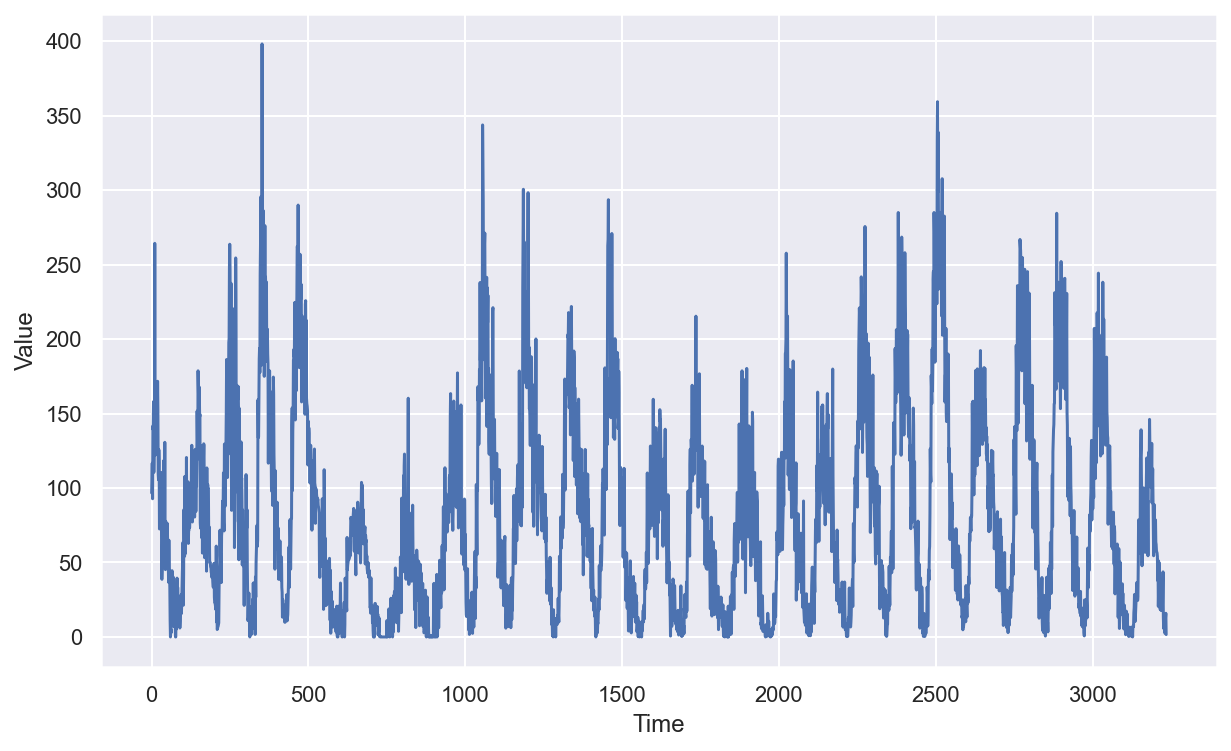

In [4]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

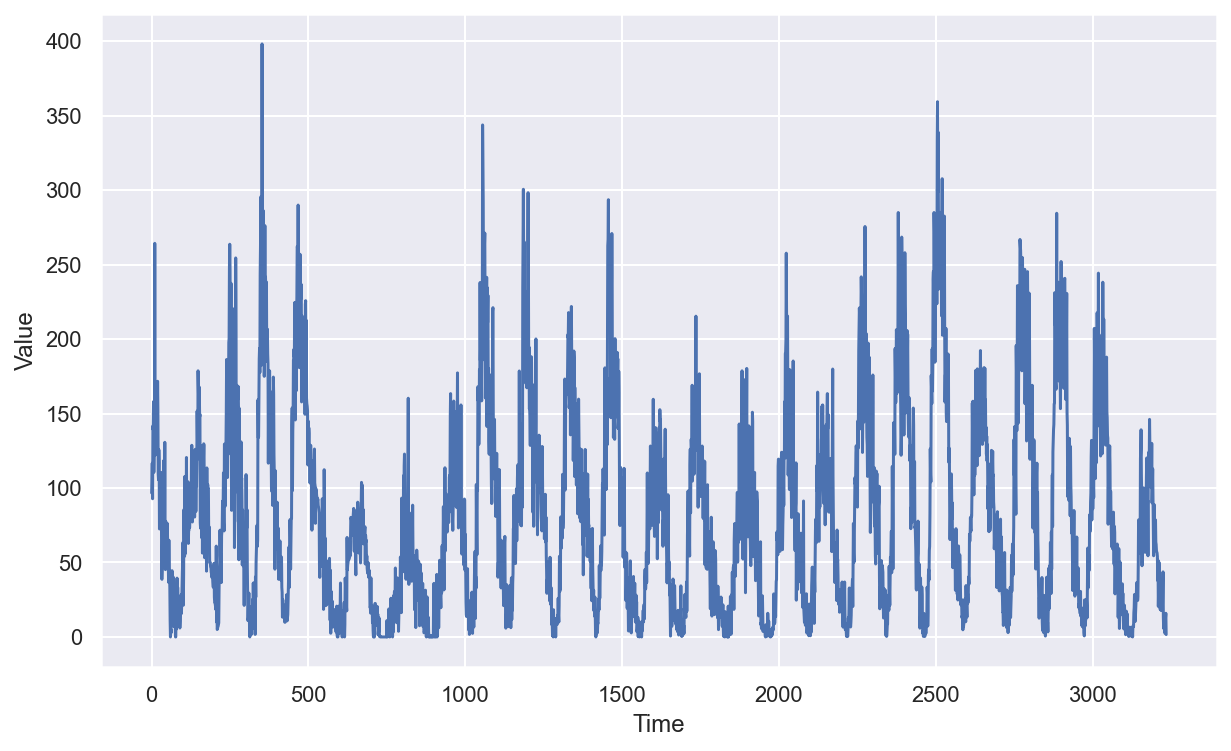

In [5]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),그게 
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 7s 236ms/step - loss: 77.0308 - mae: 77.5277
Epoch 2/100
12/12 [==============================] - 3s 223ms/step - loss: 75.8295 - mae: 76.3264
Epoch 3/100
12/12 [==============================] - 3s 250ms/step - loss: 73.8409 - mae: 74.3386
Epoch 4/100
12/12 [==============================] - 3s 223ms/step - loss: 70.0323 - mae: 70.5301
Epoch 5/100
12/12 [==============================] - 3s 226ms/step - loss: 66.1753 - mae: 66.6732
Epoch 6/100
12/12 [==============================] - 3s 190ms/step - loss: 62.9767 - mae: 63.4740
Epoch 7/100
12/12 [==============================] - 2s 173ms/step - loss: 59.8144 - mae: 60.3113
Epoch 8/100
12/12 [==============================] - 2s 187ms/step - loss: 56.0738 - mae: 56.5700
Epoch 9/100
12/12 [==============================] - 3s 223ms/step - loss: 52.7464 - mae: 53.2425
Epoch 10/100
12/

12/12 [==============================] - 3s 215ms/step - loss: 24.0066 - mae: 24.5011
Epoch 83/100
12/12 [==============================] - 3s 202ms/step - loss: 22.3718 - mae: 22.8662
Epoch 84/100
12/12 [==============================] - 2s 193ms/step - loss: 30.1846 - mae: 30.6798
Epoch 85/100
12/12 [==============================] - 3s 233ms/step - loss: 32.2384 - mae: 32.7340
Epoch 86/100
12/12 [==============================] - 3s 228ms/step - loss: 34.0827 - mae: 34.5787
Epoch 87/100
12/12 [==============================] - 3s 223ms/step - loss: 35.2518 - mae: 35.7480
Epoch 88/100
12/12 [==============================] - 3s 199ms/step - loss: 28.4641 - mae: 28.9594
Epoch 89/100
12/12 [==============================] - 2s 168ms/step - loss: 32.9283 - mae: 33.4239
Epoch 90/100
12/12 [==============================] - 2s 166ms/step - loss: 28.1263 - mae: 28.6212
Epoch 91/100
12/12 [==============================] - 2s 186ms/step - loss: 40.0191 - mae: 40.5160
Epoch 92/100
12/12 [===

(1e-08, 0.0001, 0.0, 60.0)

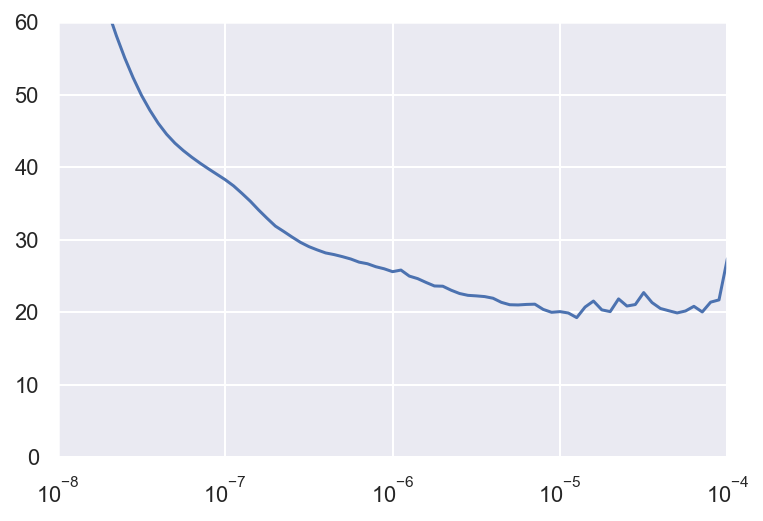

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 7s 96ms/step - loss: 47.7138 - mae: 48.2110
Epoch 2/500
30/30 [==============================] - 3s 88ms/step - loss: 26.8712 - mae: 27.3662
Epoch 3/500
30/30 [==============================] - 3s 90ms/step - loss: 22.9848 - mae: 23.4793
Epoch 4/500
30/30 [==============================] - 3s 80ms/step - loss: 20.2695 - mae: 20.7630
Epoch 5/500
30/30 [==============================] - 3s 86ms/step - loss: 19.3488 - mae: 19.8412
Epoch 6/500
30/30 [==============================] - 3s 94ms/step - loss: 19.5678 - mae: 20.0603
Epoch 7/500
30/30 [==============================] - 2s 70ms/step - loss: 18.6062 - mae: 19.0982
Epoch 8/500
30/30 [==============================] - 2s 64ms/step - loss: 17.8954 - mae: 18.3868
Epoch 9/500
30/30 [==============================] - 2s 64ms/step - loss: 17.9658 - mae: 18.4570
Epoch 10/500
30/30 [==============================] - 2s 69ms/step - loss: 18.1515 - mae: 18.6428
Epoch 11/500
30/30 [=========

30/30 [==============================] - 2s 70ms/step - loss: 16.2266 - mae: 16.7144
Epoch 85/500
30/30 [==============================] - 2s 64ms/step - loss: 16.1217 - mae: 16.6095
Epoch 86/500
30/30 [==============================] - 2s 60ms/step - loss: 16.4418 - mae: 16.9297
Epoch 87/500
30/30 [==============================] - 2s 62ms/step - loss: 16.5089 - mae: 16.9975
Epoch 88/500
30/30 [==============================] - 2s 62ms/step - loss: 16.2860 - mae: 16.7738
Epoch 89/500
30/30 [==============================] - 2s 57ms/step - loss: 16.1749 - mae: 16.6625
Epoch 90/500
30/30 [==============================] - 2s 61ms/step - loss: 16.0521 - mae: 16.5404
Epoch 91/500
30/30 [==============================] - 2s 74ms/step - loss: 16.0431 - mae: 16.5312
Epoch 92/500
30/30 [==============================] - 2s 76ms/step - loss: 16.2485 - mae: 16.7365
Epoch 93/500
30/30 [==============================] - 3s 82ms/step - loss: 16.3140 - mae: 16.8020
Epoch 94/500
30/30 [=============

30/30 [==============================] - 2s 66ms/step - loss: 15.6442 - mae: 16.1318
Epoch 168/500
30/30 [==============================] - 2s 69ms/step - loss: 15.7355 - mae: 16.2237
Epoch 169/500
30/30 [==============================] - 2s 73ms/step - loss: 15.4672 - mae: 15.9546
Epoch 170/500
30/30 [==============================] - 2s 73ms/step - loss: 15.5462 - mae: 16.0338
Epoch 171/500
30/30 [==============================] - 2s 76ms/step - loss: 15.6478 - mae: 16.1354
Epoch 172/500
30/30 [==============================] - 2s 78ms/step - loss: 15.7334 - mae: 16.2210
Epoch 173/500
30/30 [==============================] - 2s 73ms/step - loss: 15.7052 - mae: 16.1929
Epoch 174/500
30/30 [==============================] - 2s 75ms/step - loss: 15.7320 - mae: 16.2190
Epoch 175/500
30/30 [==============================] - 2s 77ms/step - loss: 15.7465 - mae: 16.2343
Epoch 176/500
30/30 [==============================] - 2s 77ms/step - loss: 15.9030 - mae: 16.3910
Epoch 177/500
30/30 [===

30/30 [==============================] - 2s 72ms/step - loss: 15.9647 - mae: 16.4526
Epoch 250/500
30/30 [==============================] - 2s 59ms/step - loss: 15.4970 - mae: 15.9841
Epoch 251/500
30/30 [==============================] - 2s 64ms/step - loss: 15.2808 - mae: 15.7674
Epoch 252/500
30/30 [==============================] - 2s 70ms/step - loss: 15.5328 - mae: 16.0195
Epoch 253/500
30/30 [==============================] - 2s 77ms/step - loss: 15.1415 - mae: 15.6274
Epoch 254/500
30/30 [==============================] - 2s 75ms/step - loss: 15.2047 - mae: 15.6915
Epoch 255/500
30/30 [==============================] - 2s 72ms/step - loss: 15.2126 - mae: 15.6992
Epoch 256/500
30/30 [==============================] - 3s 79ms/step - loss: 15.0632 - mae: 15.5497
Epoch 257/500
30/30 [==============================] - 2s 73ms/step - loss: 15.3102 - mae: 15.7966
Epoch 258/500
30/30 [==============================] - 3s 85ms/step - loss: 15.1033 - mae: 15.5892
Epoch 259/500
30/30 [===

30/30 [==============================] - 2s 77ms/step - loss: 14.8846 - mae: 15.3700
Epoch 332/500
30/30 [==============================] - 3s 84ms/step - loss: 14.7762 - mae: 15.2605
Epoch 333/500
30/30 [==============================] - 3s 82ms/step - loss: 14.8935 - mae: 15.3777
Epoch 334/500
30/30 [==============================] - 3s 85ms/step - loss: 14.9073 - mae: 15.3922
Epoch 335/500
30/30 [==============================] - 3s 82ms/step - loss: 14.7628 - mae: 15.2462
Epoch 336/500
30/30 [==============================] - 2s 75ms/step - loss: 14.8572 - mae: 15.3419
Epoch 337/500
30/30 [==============================] - 2s 77ms/step - loss: 15.0013 - mae: 15.4869
Epoch 338/500
30/30 [==============================] - 2s 75ms/step - loss: 14.8724 - mae: 15.3561
Epoch 339/500
30/30 [==============================] - 2s 76ms/step - loss: 14.7889 - mae: 15.2740
Epoch 340/500
30/30 [==============================] - 2s 71ms/step - loss: 14.8013 - mae: 15.2861
Epoch 341/500
30/30 [===

30/30 [==============================] - 3s 79ms/step - loss: 14.5040 - mae: 14.9882
Epoch 414/500
30/30 [==============================] - 2s 77ms/step - loss: 14.4595 - mae: 14.9433
Epoch 415/500
30/30 [==============================] - 2s 79ms/step - loss: 14.6497 - mae: 15.1345
Epoch 416/500
30/30 [==============================] - 2s 75ms/step - loss: 14.8421 - mae: 15.3275
Epoch 417/500
30/30 [==============================] - 2s 65ms/step - loss: 14.6499 - mae: 15.1347
Epoch 418/500
30/30 [==============================] - 2s 60ms/step - loss: 14.5752 - mae: 15.0594
Epoch 419/500
30/30 [==============================] - 2s 61ms/step - loss: 14.5796 - mae: 15.0635
Epoch 420/500
30/30 [==============================] - 2s 67ms/step - loss: 14.6274 - mae: 15.1116
Epoch 421/500
30/30 [==============================] - 2s 77ms/step - loss: 14.4549 - mae: 14.9387
Epoch 422/500
30/30 [==============================] - 3s 93ms/step - loss: 14.4473 - mae: 14.9313
Epoch 423/500
30/30 [===

30/30 [==============================] - 3s 79ms/step - loss: 14.2342 - mae: 14.7176
Epoch 496/500
30/30 [==============================] - 3s 82ms/step - loss: 14.2503 - mae: 14.7343
Epoch 497/500
30/30 [==============================] - 2s 70ms/step - loss: 14.3317 - mae: 14.8155
Epoch 498/500
30/30 [==============================] - 2s 62ms/step - loss: 14.2494 - mae: 14.7340
Epoch 499/500
30/30 [==============================] - 2s 64ms/step - loss: 14.4601 - mae: 14.9451
Epoch 500/500
30/30 [==============================] - 2s 68ms/step - loss: 14.3498 - mae: 14.8342


In [12]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

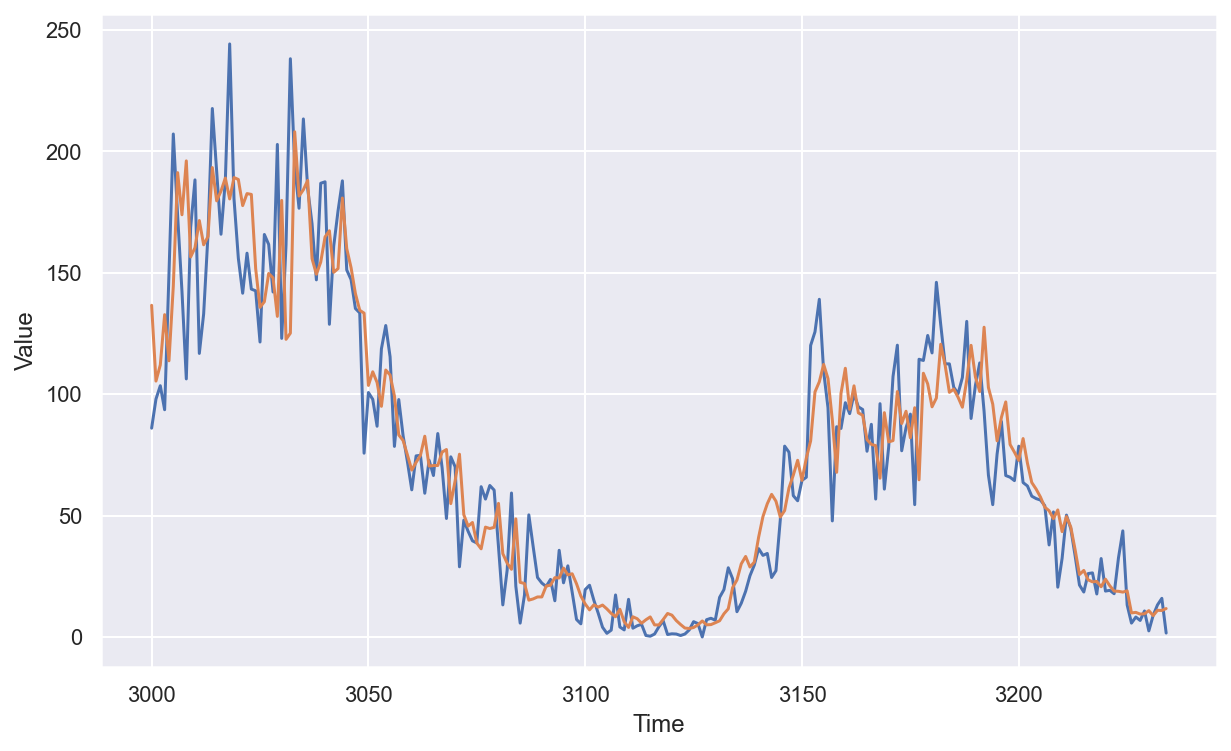

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

14.817902

<Figure size 432x288 with 0 Axes>

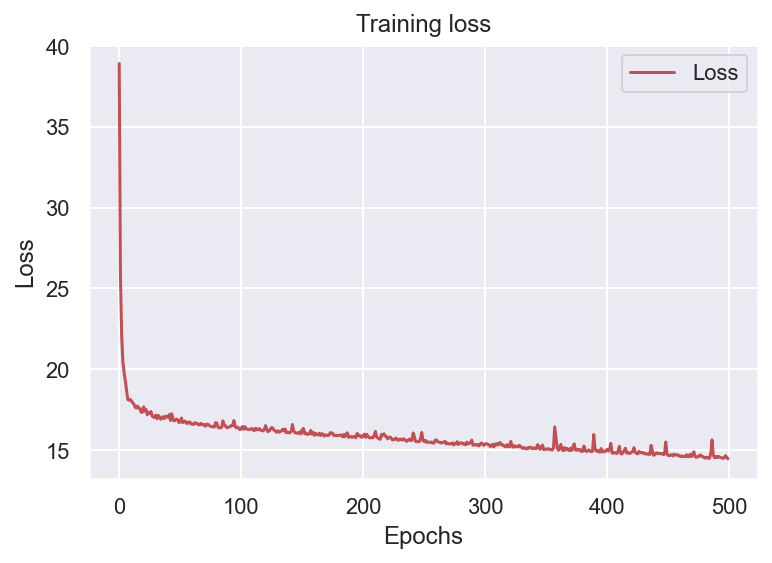

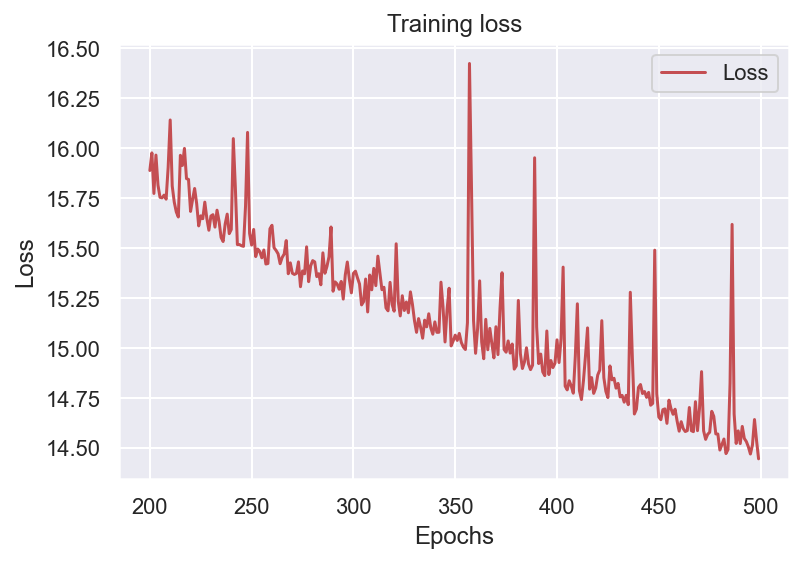

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [16]:
print(rnn_forecast)

[136.63075   105.41283   112.05275   132.77753   113.75418   144.55612
 191.28096   173.92435   196.11914   156.54767   160.3522    171.54634
 161.55676   164.94362   193.36888   179.66232   183.69739   189.04242
 180.4424    189.2524    188.46674   177.69759   182.64507   182.31204
 151.65372   135.79425   138.10193   149.74318   147.93327   132.0582
 179.83784   122.61791   125.14045   208.11803   181.62231   184.23328
 188.07724   155.83466   149.42508   154.41971   164.79463   167.33353
 150.20523   151.7704    180.82373   159.9812    152.12872   141.46779
 134.58287   133.39552   103.6157    109.22845   104.828285   95.006256
 109.96859   107.919      99.25692    83.213066   80.93475    74.9714
  68.739716   71.91389    74.82196    82.69442    70.377556   70.61003
  70.619194   76.158455   77.21627    54.93095    64.315926   75.28612
  50.372704   45.65223    47.1531     38.69079    36.299736   45.23977
  44.670418   45.153034   55.03646    34.312405   30.400272   27.87278
  48.65